# Author: Samar Singh 

# Predicting Housing Prices in Cook County


## Introduction/Overview

After completing Exploratory Data Analysis (EDA), we will specify and fit a linear model to a few features of the housing data to predict house prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of the modeling results as you work through this project, and think about what fairness might mean to property owners in Cook County.


In [12]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training, validation, and test data.

In [13]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training set, a validation set, and a test set. Importantly, the test set does not contain values for our target variable, `Sale Price`. In this project,will train a model on the training and validation sets and then use this model to predict the `Sale Price`s of the test set. In the cell below, we load the training and validation sets into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [14]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the shape of the data matches the description.

In [15]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. 

In [16]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

# Human Context and Ethics, How much is a house worth?

listing  least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price be low or high.**

1.) Homebuyer - interested in seeking lower housing prices 2.) Homeseller - seeking higher housing prices 3.) Tax Collecting Gov Institutions - seeking higher housing prices to stimulate and collect higher inflow of taxes.

Things that strikes me as unfair in the context of CCAO where we understand that different segregated neighborhoods faced inaccurate home valuations. To expand further, lower income households (i.e neighborhoods with lower home value) were being faced with overvaluations of their properties which increased their effective tax rate, while wealthier neighborhoods with higher prices were under-valued. Proportionally speaking, their was a major unequal disconnect present between the effective tax rates from the two social classes/neighborhoods. Describes the CCAO housing crisis scenario perfectly as there was transpiring an unfair overvaluation and undervaluation of homes not only based on the features of the property itself, but additionally concerning Cook County socioeconomic divisions that ultimately steered each homeowner's, rich or poor effective tax rate discriminately. C can be considered less fair relative to the other options due to the effective tax rate reasoning and the targeted valuations.


## The CCAO Dataset

We will work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

However, this system is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines. Wealthy homeowners, who were typically white, [paid less in property taxes](https://fix8media-chicago.squarespace.com/bpnc-v-berrios-resource-page), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)," delves into how this was uncovered. After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." 

### Central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune? What were the primary causes of these problems? 

The central problem of the tax system implemented in Cook Country was the disproportionate effective tax rates across a racial divide of properties in Cook County. Digging deeper, the Assessor's Office possessed the authority to assess a property's value based on their statistical model and selected features/factors which skewed property valuations in favor of white, wealthier neighborhoods where higher priced homes were undervalued, while the converse effect occurred with lower priced homes - sparking a deep divide and inequality of effective tax rates paid. The tribune article touched on several key reasons that may have caused this divide such as the outdated mainframe computers used to compute the regressive models, lack of transparency caused by infrequent examinations, failure to accurately model after the 2008 housing crisis, and an overall ignorance to the tools used in the CCAO. The article exposed the high COD( Coefficient of Dispersion) of 31 that was primarily observed in townships (standard "fair" COD is considered to be 15). 

### Regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

CCAO overvaluing properties that were priced low, while undervaluing higher priced homes (regressivity) led to  granting the majority white property owners wealthy unsanctioned tax breaks, and inequality in tax bills that tortured low-income residents. Another culprit outside of regressivity is the lack of transparency in the CCAO and the notion of taxation without further explanation. Furthermore, lack of modern computing infastructure and poor statistical methods cause also play a role in disproportionate tax burdens on non-white property owners as those residing in low-priced neighborhoods are facing higher propotional effective tax rates to those in wealthier neighborhoods.

## Preparing Data


Split the dataset into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits `data` into two smaller `DataFrame`s named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20%.

In [ ]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. 

np.random.seed(1337)

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices, val_indices = shuffled_indices[0:int(data_len*.80)], shuffled_indices[int(
        data_len*.80):data_len]
    train = data.loc[train_indices,:]
    validation = data.loc[val_indices, :]
   
    return train, validation
train, validation = train_val_split(training_val_data)
validation.shape



## Fitting a Simple Model

Let's fit our linear regression model using the ordinary least squares estimator! We will start with something simple by using only two features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our first linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a second model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br>

### Pipeline Function


In [ ]:
from feature_func import *  



def feature_engine_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedroom column
    data = add_total_bedrooms(data)
    # Select X and Y from the full data
    X = data[['Bedrooms']]
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = feature_engine_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = feature_engine_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

### `.pipe`

Alternatively, we can build the pipeline using `pd.DataFrame.pipe` 

We can use this function with each of the tuples passed in through `pipeline_functions`.

In [ ]:
# Run this cell to define feature_engine_pipe; no further action is needed.
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y


## Validation/Training Data

It is time to prepare the training and validation data for the two models we proposed above. Use the following two cells to reload a fresh dataset from scratch and run them through the following preprocessing steps using `feature_engine_pipe` for each model:

- Perform a `train_val_split` on the original dataset, loaded as the `DataFrame` `full_data`. Let 80% of the set be training data, and 20% of the set be validation data. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price` so that we consider households with a price that is greater than 499 dollars (or equivalently, a price that is 500 dollars or greater). 
    2. Apply log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` if this is the second model). We have implemented the helper function `select_columns`.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. 
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

In [ ]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Apply feature engineering to the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, Y_train_m1 = feature_engine_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = feature_engine_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by feature_engine_simple
display(X_train_m1.head())
display(Y_train_m1.head())

In [ ]:
np.random.seed(1337)

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [(remove_outliers, None, {'variable':'Sale Price', 'lower':499,}),
                (log_transform, None, {'col': 'Sale Price'}),
                (log_transform, None, {'col': 'Building Square Feet'}),
                (add_total_bedrooms, None, None),
                (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)]

X_train_m2, Y_train_m2 = feature_engine_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = feature_engine_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

<br>

--- 

## Regression



In [ ]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [ ]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)
# Compute the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)



## Evaluate Our Simple Model


Let's now move into the analysis of our two models!

In [ ]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))


## True

One way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.


In [ ]:
plt.title(f'Model 2: RMSE Log Sale Price on the Validation Set is: {rmse(Y_valid_m2, Y_predicted_m2)} ')
plt.scatter(x = Y_valid_m2 , y = (Y_valid_m2 - Y_predicted_m2) , alpha = .15, s = 5)
plt.axhline(y = 0, color = 'red')
plt.xlabel('Y Log Sale Price')
plt.ylabel('Residual')
plt.grid(which = 'both')

# Build model!

We will conduct feature engineering on our training data using the `feature_engine_final` function (we will define this in `q5d`), fit the model with this training data, and compute the training Root Mean Squared Error (RMSE). Then, we will process our test data with `feature_engine_final`, use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

# GOAL:

* Define a function to perform feature engineering and produce a design matrix for modeling.
* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses.
* Use this trained model to predict the `Log Sale Price`s of the test set. Remember that our test set does not contain the true `Sale Price` of each house –—  model is trying to guess them! 

In [ ]:


%reset -f                               

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression


## Finding Potential Features


Useful features in predicting housing prices: Land Square Feet, Building Square Feet, 'Property Class', "O'Hare Noise", 'Central Air','Repair Condition', 'Garage Indicator'



## More EDA/key questions

    
* Plot the distribution of a variable. 

* scatter plot between a continuous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?



In [30]:
#Setup
full_data = pd.read_csv("cook_county_train.csv")
XX = full_data.copy()
XX = remove_outliers(XX, 'Sale Price', lower = 499, upper = 3000000)
sales = np.log(XX['Sale Price'])
XX = XX.drop('Sale Price', axis = 1)
XX = substitute_roof_material(XX)
XX = add_total_bedrooms(XX)
XX = log_transform(XX, 'Land Square Feet')
XX.columns


Index(['Unnamed: 0', 'PIN', 'Property Class', 'Neighborhood Code',
       'Land Square Feet', 'Town Code', 'Apartments', 'Wall Material',
       'Roof Material', 'Basement', 'Basement Finish', 'Central Heating',
       'Other Heating', 'Central Air', 'Fireplaces', 'Attic Type',
       'Attic Finish', 'Design Plan', 'Cathedral Ceiling',
       'Construction Quality', 'Site Desirability', 'Garage 1 Size',
       'Garage 1 Material', 'Garage 1 Attachment', 'Garage 1 Area',
       'Garage 2 Size', 'Garage 2 Material', 'Garage 2 Attachment',
       'Garage 2 Area', 'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Longitude',
       'Latitude', 'Census Tract', 'Multi Property Indicator',
       'Modeling Group', 'Age', 'Use', 'O'Hare Noise', 'Floodplain',
       'Road Proximity', 'Sale Year', 'Sale Quarter', 'Sale Half-Year',
       'Sale Quarter of Year'

In [31]:
for i in full_data.columns:
    print(f'{i} unique values: {full_data[i].unique().shape[0]}')

Unnamed: 0 unique values: 204792
PIN unique values: 167191
Property Class unique values: 9
Neighborhood Code unique values: 193
Land Square Feet unique values: 18605
Town Code unique values: 38
Apartments unique values: 3
Wall Material unique values: 4
Roof Material unique values: 6
Basement unique values: 4
Basement Finish unique values: 2
Central Heating unique values: 3
Other Heating unique values: 2
Central Air unique values: 2
Fireplaces unique values: 3
Attic Type unique values: 3
Attic Finish unique values: 3
Design Plan unique values: 3
Cathedral Ceiling unique values: 3
Construction Quality unique values: 3
Site Desirability unique values: 3
Garage 1 Size unique values: 8
Garage 1 Material unique values: 5
Garage 1 Attachment unique values: 3
Garage 1 Area unique values: 3
Garage 2 Size unique values: 7
Garage 2 Material unique values: 3
Garage 2 Attachment unique values: 3
Garage 2 Area unique values: 4
Porch unique values: 3
Other Improvements unique values: 1027
Building Sq

In [32]:
#Reasonable columns to hot encode
for i in full_data.columns:
    if full_data[i].unique().shape[0] <= 10:
        print(f'{i} unique values: {full_data[i].unique().shape[0]}')

Property Class unique values: 9
Apartments unique values: 3
Wall Material unique values: 4
Roof Material unique values: 6
Basement unique values: 4
Basement Finish unique values: 2
Central Heating unique values: 3
Other Heating unique values: 2
Central Air unique values: 2
Fireplaces unique values: 3
Attic Type unique values: 3
Attic Finish unique values: 3
Design Plan unique values: 3
Cathedral Ceiling unique values: 3
Construction Quality unique values: 3
Site Desirability unique values: 3
Garage 1 Size unique values: 8
Garage 1 Material unique values: 5
Garage 1 Attachment unique values: 3
Garage 1 Area unique values: 3
Garage 2 Size unique values: 7
Garage 2 Material unique values: 3
Garage 2 Attachment unique values: 3
Garage 2 Area unique values: 4
Porch unique values: 3
Repair Condition unique values: 3
Multi Code unique values: 7
Number of Commercial Units unique values: 4
Multi Property Indicator unique values: 2
Modeling Group unique values: 1
Use unique values: 1
O'Hare Nois

In [33]:
arr = ['Land Square Feet', 'Building Square Feet', 'Lot Size', 'Bedrooms', 'Age Decade']
for i in arr:
    print(f"{i} mean: {np.mean(XX[i])}Correlation Coeff:{np.corrcoef( XX[i], sales)[0][1]}")

Land Square Feet mean: 7961.52875335642Correlation Coeff:0.12763594883001558
Building Square Feet mean: 1620.4441460508297Correlation Coeff:0.5641742420415619
Lot Size mean: 7961.52875335642Correlation Coeff:0.12763594883001558
Bedrooms mean: 3.209745021668119Correlation Coeff:0.4226747199597078
Age Decade mean: 6.482905010048553Correlation Coeff:-0.24865195401084347


In [34]:
np.quantile(sales, .999)

14.761360092079974

In [35]:
#RMSE: 378750.42170374584 try 1
#"O'Hare Noise"

In [36]:

#Test Econding
def one_hot_encode_revised(data):
    data_joinable = data[['Land Square Feet', 'Building Square Feet']]
    non_numeric_1 = ['Property Class', "O'Hare Noise", 'Central Air', 
                     'Garage Indicator', 'Bedrooms', 'Roof Material', 'Design Plan', 'Repair Condition', 'Garage 1 Size']
    encoder = OneHotEncoder()
    encoder.fit(data[non_numeric_1])
    encoded_data_1 = encoder.transform(data[non_numeric_1]).toarray()
    new_frame = pd.DataFrame(data = encoded_data_1, columns = encoder.get_feature_names_out(), index = data.index)
    #featured_frame = new_frame.drop(columns = non_numeric_1)
    new_frame['bias'] = np.ones(len(new_frame), dtype = int)
    feat = data_joinable.join(new_frame)
    return feat.drop(columns =["O'Hare Noise_0.0", 'Garage Indicator_0.0','Property Class_207', 'Bedrooms_9',
                                   'Central Air_0.0', 'Roof Material_Tile',
                               'Design Plan_1.0', 'Garage 1 Size_6.0' ])
    


one_hot_prop = one_hot_encode_revised(XX)
display(one_hot_prop.columns)
#Check rank
print("one_hot_X: \n"
      + "\t number of columns: " + str(len(one_hot_prop.columns)) \
      + "\trank: " + str(np.linalg.matrix_rank(one_hot_prop)))
#Check Thetas
ana = LinearRegression()
ana.fit(one_hot_prop, sales)
print('RMSE:',rmse(np.exp(sales),np.exp(ana.predict(one_hot_prop))))
print(one_hot_prop.columns)

Index(['Land Square Feet', 'Building Square Feet', 'Property Class_202',
       'Property Class_203', 'Property Class_204', 'Property Class_205',
       'Property Class_206', 'Property Class_208', 'Property Class_209',
       'Property Class_278', 'O'Hare Noise_1.0', 'Central Air_1.0',
       'Garage Indicator_1.0', 'Bedrooms_1', 'Bedrooms_2', 'Bedrooms_3',
       'Bedrooms_4', 'Bedrooms_5', 'Bedrooms_6', 'Bedrooms_7', 'Bedrooms_8',
       'Bedrooms_10', 'Bedrooms_14', 'Roof Material_Other',
       'Roof Material_Shake', 'Roof Material_Shingle/Asphalt',
       'Roof Material_Slate', 'Roof Material_Tar&Gravel', 'Design Plan_0.0',
       'Design Plan_2.0', 'Repair Condition_1.0', 'Repair Condition_2.0',
       'Repair Condition_3.0', 'Garage 1 Size_0.0', 'Garage 1 Size_1.0',
       'Garage 1 Size_2.0', 'Garage 1 Size_3.0', 'Garage 1 Size_4.0',
       'Garage 1 Size_5.0', 'Garage 1 Size_7.0', 'bias'],
      dtype='object')

one_hot_X: 
	 number of columns: 41	rank: 39
RMSE: 363694.98612648476
Index(['Land Square Feet', 'Building Square Feet', 'Property Class_202',
       'Property Class_203', 'Property Class_204', 'Property Class_205',
       'Property Class_206', 'Property Class_208', 'Property Class_209',
       'Property Class_278', 'O'Hare Noise_1.0', 'Central Air_1.0',
       'Garage Indicator_1.0', 'Bedrooms_1', 'Bedrooms_2', 'Bedrooms_3',
       'Bedrooms_4', 'Bedrooms_5', 'Bedrooms_6', 'Bedrooms_7', 'Bedrooms_8',
       'Bedrooms_10', 'Bedrooms_14', 'Roof Material_Other',
       'Roof Material_Shake', 'Roof Material_Shingle/Asphalt',
       'Roof Material_Slate', 'Roof Material_Tar&Gravel', 'Design Plan_0.0',
       'Design Plan_2.0', 'Repair Condition_1.0', 'Repair Condition_2.0',
       'Repair Condition_3.0', 'Garage 1 Size_0.0', 'Garage 1 Size_1.0',
       'Garage 1 Size_2.0', 'Garage 1 Size_3.0', 'Garage 1 Size_4.0',
       'Garage 1 Size_5.0', 'Garage 1 Size_7.0', 'bias'],
      dtype='objec

Min Error:4.649480769251908 Coeff: 0.13280891223033048


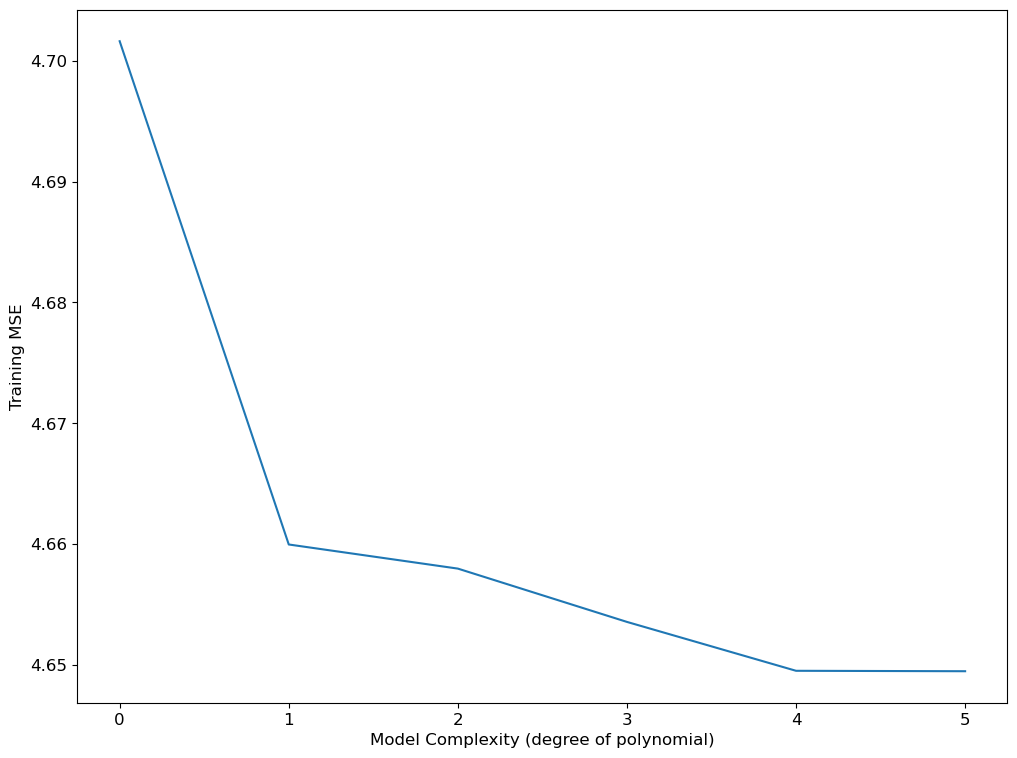

In [41]:
testing = full_data.copy()
testing['Log Total'] = np.log(testing['Land Square Feet'] + testing['Building Square Feet'])
# testing.loc[testing['Estimate (Building)']<= 0] = meaner
testing['Log Estimate (Building)'] = np.log(testing['Estimate (Building)'])
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
testing['Log Sale Price'] = np.log(testing['Sale Price'])
def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', LinearRegression())    
        ])

    pipelined_model.fit(np.log(dataset[['Lot Size']]), dataset["Log Sale Price"])
    return rmse(dataset['Log Sale Price'], pipelined_model.predict(np.log(dataset[['Lot Size']])))

errors = [fit_model_dataset(degree, testing) for degree in range(0, 6,1)]
#MSEs_and_k = pd.DataFrame({"k": range(0, 8), "RMSE": errors})

plt.plot(range(0, 6), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training MSE");
coeff = np.corrcoef(np.log(testing['Lot Size']), testing['Log Sale Price'])[0][1]
print(f'Min Error:{min(errors)} Coeff: {coeff}')
#Log Total:
#4.683511839934628: exponentiating by 3
#4.638283896721328 logging total
#Building:
# 4.659622492893698 
#4.620080909882658


## Defining Helper Function or Helper Variables



In [42]:

#removed variables: Property Class, Garage Indicator
def property_hot_encoder(data):
    data_joinable = data[['Log Building Square Feet', 'Log Land Square Feet','Log Estimate (Building)', 'Lot Size', 'Log Estimate (Land)']]
    non_numeric_1 = ['Garage 1 Size', 'Bedrooms']
    encoder = OneHotEncoder()
    encoder.fit(data[non_numeric_1])
    encoded_data_1 = encoder.transform(data[non_numeric_1]).toarray()
    new_frame = pd.DataFrame(data = encoded_data_1, columns = encoder.get_feature_names_out(), index = data.index)
    #featured_frame = new_frame.drop(columns = non_numeric_1)
    #new_frame['bias'] = np.ones(len(new_frame), dtype = int)
    newer_frame = new_frame.join(data_joinable)
    return newer_frame.drop(columns =['Garage 1 Size_6.0' , 'Bedrooms_7'])




## Defining The Pipeline Function and Feature Engineering


In [43]:

def feature_engine_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        data['Log Sale Price'] = np.log(data['Sale Price'])
        upperr = np.quantile(data['Sale Price'], .99)
        data = remove_outliers(data, 'Sale Price', lower= 499, upper = upperr)
        data = substitute_roof_material(data)
        data['Log Total Area'] = np.log(data['Building Square Feet'] + data['Land Square Feet'])
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        data= add_total_bedrooms(data)
        data = substitute_roof_material(data)
        data['Log Total Area'] = np.log(data['Building Square Feet'] +data['Land Square Feet'])

        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    data = log_transform(data, 'Building Square Feet')
    data = log_transform(data, 'Land Square Feet')
    data= add_total_bedrooms(data)
    data.loc[data["Bedrooms"] > 10] = np.mean(data["Bedrooms"]).astype(int)
    data['Log Total Area'] = np.log(data['Building Square Feet'] +data['Land Square Feet'])
    data = substitute_roof_material(data)
    data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'] +.01)
    data['Log Estimate (Land)'] = np.log(data['Estimate (Land)'] +.01)
    data['Log Lot Size'] = np.log(data['Lot Size'])
    data.loc[data['Garage 1 Size'] == 7] = 0
    

    #data = log_transform(data, 'Estimate (Building)')
    
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors 
        #X =data[['Log Total Area', 'Log Estimate (Building)', 'Log Lot Size']]
        X = property_hot_encoder(data)
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X = property_hot_encoder(data)
        #X = data[['Log Total Area', 'Log Estimate (Building)', 'Lot Size', 'Log Estimate (Land)']]
        # Response variable
        Y = data['Log Sale Price']
        
        return X, Y

check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), feature_engine_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)
print("Check prediction ")

Current training RMSE: 156149.02516904383
Check prediction 


## Fit and Evaluate the Model


$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$


In [44]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [46]:
from sklearn.model_selection import train_test_split\
# type(train_test_split)

In [49]:

def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices, val_indices = shuffled_indices[0:int(data_len*.80)], shuffled_indices[int(
        data_len*.80):data_len]
    train = data.loc[train_indices,:]
    validation = data.loc[val_indices, :]
   
    return train, validation 
from sklearn.linear_model import LinearRegression
full_data = pd.read_csv("cook_county_train.csv")
X_Train_set, X_Val_set = train_val_split(full_data)
X_train_simple, Y_train_simple = feature_engine_final(X_Train_set, is_test_set=False)
X_val_simple, Y_val_simple = feature_engine_final(X_Val_set, is_test_set=False)
model = LinearRegression(fit_intercept = True)
model.fit(X_train_simple, Y_train_simple)
Y_fitted_s = model.predict(X_train_simple)
#Y_predicted_s= linear_model_m1.predict(X_valid_m1)
num1 = rmse(np.exp(Y_fitted_s), np.exp(Y_train_simple))
#Test Set
model2 = LinearRegression(fit_intercept = True)
model2.fit(X_val_simple, Y_val_simple)
Y_fitted_s2 = model2.predict(X_val_simple)
num2 = rmse(np.exp(Y_fitted_s2), np.exp(Y_val_simple))
display(num1, num2)


155617.72267275528

157936.88460074004

In [58]:
from datetime import datetime
from IPython.display import display, HTML

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), feature_engine_final, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )


In [59]:
full_data = pd.read_csv("cook_county_train.csv")
X, Y = feature_engine_final(full_data, False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2,  
                                                    shuffle=True)

for i in range(1, 8):
    X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    model = lm.LinearRegression()
    model.fit(X_train_mini, Y_train_mini)
    y_hat = model.predict(X_val)
    print(f"Val error from train/validation split #{i}: {rmse(np.exp(y_hat), np.exp(Y_val))}")

Val error from train/validation split #1: 151724.52822292538
Val error from train/validation split #2: 154510.6185019723
Val error from train/validation split #3: 157414.8372024373
Val error from train/validation split #4: 154631.59494555992
Val error from train/validation split #5: 153660.63015450232
Val error from train/validation split #6: 153236.08127052526
Val error from train/validation split #7: 157641.83521592972


Congratulations on finishing your prediction model for home sale prices in Cook County! In the following section, we'll delve deeper into the implications of predictive modeling within the CCAO case study, especially because statistical modeling is how the CCAO valuates properties. 

Refer to [Lecture 15](https://ds100.org/sp24/lecture/lec15/) if you're having trouble getting started!

## Exploring RMSE

Let's delve a bit deeper into what RMSE means in the context of predicting house prices. We will go through different ways of visualizing the performance of the model you created and see how that ties into questions about property taxes. To this end, we'll create the `preds_df` `DataFrame`.

In [52]:
# Run the cell below; no further action is needed
train_df = pd.read_csv('cook_county_train.csv')
X, Y_true = feature_engine_final(train_df)
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, Y_true)
Y_pred = model.predict(X)

In [53]:
preds_df = pd.DataFrame({'True Log Sale Price' : Y_true, 'Predicted Log Sale Price' : Y_pred, 
                         'True Sale Price' : np.e**Y_true, 'Predicted Sale Price' : np.e**Y_pred})
preds_df.head()

,True Log Sale Price,Predicted Log Sale Price,True Sale Price,Predicted Sale Price
1,12.560244,12.095974,285000.0,179149.083686
2,9.998798,11.514816,22000.0,100189.226522
3,12.323856,11.862731,225000.0,141879.214737
4,10.025705,11.235748,22600.0,75791.980605
6,11.512925,12.104083,100000.0,180607.830538


<br>

---
### Examine on below and above median threshold

Let's examine how our model performs on two halves of our data: `cheap_df` which contains the rows of `preds_df` with prices below or equal to the median sale price, and `expensive_df` which has rows of `preds_df` with true sale prices above the median.  

In [54]:
# Run the cell below to obtain the two subsets of data; no further action is needed.
min_Y_true, max_Y_true = np.round(np.min(Y_true), 1) , np.round(np.max(Y_true), 1)
median_Y_true = np.round(np.median(Y_true), 1)
cheap_df = preds_df[(preds_df['True Log Sale Price'] >= min_Y_true) & (preds_df['True Log Sale Price'] <= median_Y_true)]
expensive_df = preds_df[(preds_df['True Log Sale Price'] > median_Y_true) & (preds_df['True Log Sale Price'] <= max_Y_true)]

print(f'\nThe lower interval contains houses with true sale price ${np.round(np.e**min_Y_true)} to ${np.round(np.e**median_Y_true)}')
print(f'The higher interval contains houses with true sale price ${np.round(np.e**median_Y_true)} to ${np.round(np.e**max_Y_true)}\n')


The lower interval contains houses with true sale price $1.0 to $219696.0
The higher interval contains houses with true sale price $219696.0 to $1468864.0



**RMSE of the model's predictions of `Sale Price` on each subset separately**, and assigned  values of `rmse_cheap` and `rmse_expensive` respectively.

In [55]:
rmse_cheap = rmse(cheap_df['Predicted Sale Price'], cheap_df['True Sale Price'])
rmse_expensive = rmse(expensive_df['Predicted Sale Price'], expensive_df['True Sale Price'])
#COmpute overestimations
prop_overest_cheap = (cheap_df.loc[(cheap_df['True Sale Price'] - cheap_df['Predicted Sale Price']) < 0].shape[0])/len(cheap_df)
prop_overest_expensive = (expensive_df.loc[(expensive_df['True Sale Price'] - expensive_df['Predicted Sale Price']) < 0].shape[0])/len(expensive_df)

print(f"The RMSE for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(rmse_cheap)}")
print(f"The RMSE for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(rmse_expensive)}\n")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(100 * prop_overest_cheap, 2)}%")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(100 * prop_overest_expensive, 2)}%")

The RMSE for properties with log sale prices in the interval (0.0, 12.3) is 88651.0
The RMSE for properties with log sale prices in the interval (12.3, 14.2) is 204328.0

The percentage of overestimated values for properties with log sale prices in the interval (0.0, 12.3) is 59.03%
The percentage of overestimated values for properties with log sale prices in the interval (12.3, 14.2) is 21.76%



### Fine Grained Approach RMSE and Overestimation

 Let's try and take a more fine-grained approach to understand how RMSE and proportion of houses overestimated vary across different intervals of `Log Sale Price`. `rmse_interval` and `prop_overest_interval`  allow us to compute the appropriate values for any given interval. 

In [56]:
def rmse_interval(df, start, end):
    '''
    Given a design matrix X and response vector Y, computes the RMSE for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval [start, end].

    Input: 
    df : pandas DataFrame with columns 'True Log Sale Price', 
        'Predicted Log Sale Price', 'True Sale Price', 'Predicted Sale Price'
    start : A float specifying the start of the interval (inclusive)
    end : A float specifying the end of the interval (inclusive)
    '''

    subset_df = df[(df['True Log Sale Price'] >= start) & (df['True Log Sale Price'] <= end)]

    rmse_subset = rmse(subset_df['Predicted Sale Price'], subset_df['True Sale Price'])
    return rmse_subset
    
def prop_overest_interval(df, start, end):
    '''
    Given a DataFrame df, computes prop_overest for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval [start, end].

    Input: 
    df : pandas DataFrame with columns 'True Log Sale Price', 
        'Predicted Log Sale Price', 'True Sale Price', 'Predicted Sale Price'
    start : A float specifying the start of the interval (inclusive)
    end : A float specifying the end of the interval (inclusive)
    '''
    
    subset_df = df[(df['True Log Sale Price'] >= start) & (df['True Log Sale Price'] <= end)]

    if subset_df.shape[0] == 0:
        return -1

    prop_subset = (subset_df.loc[(subset_df['True Sale Price'] - subset_df['Predicted Sale Price']) < 0].shape[0])/len(subset_df)
    return prop_subset


### Visuals! (RMSE Edition)

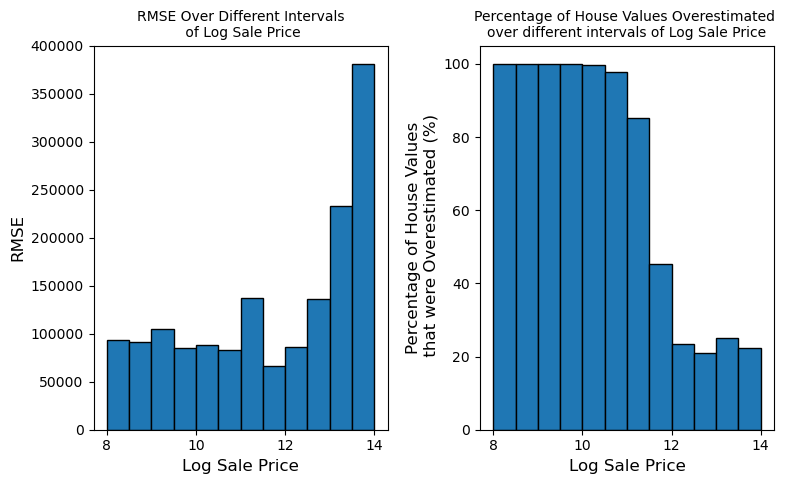

In [57]:
# RMSE plot
plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1) 
rmses = []
for i in np.arange(8, 14, 0.5):
    rmses.append(rmse_interval(preds_df, i, i + 0.5))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = rmses, edgecolor = 'black', width = 0.5)
plt.title('RMSE Over Different Intervals\n of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('RMSE')

# Overestimation plot  
plt.subplot(1, 2, 2)
props = []
for i in np.arange(8, 14, 0.5):
    props.append(prop_overest_interval(preds_df, i, i + 0.5) * 100) 
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = props, edgecolor = 'black', width = 0.5)
plt.title('Percentage of House Values Overestimated \nover different intervals of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('Percentage of House Values\n that were Overestimated (%)')

plt.tight_layout()
plt.show()

Our empirical visual derived on the right aligns closely with the description of Scenario where: "An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties. " as we see a clear overestimation divide between proportions of house values overestimated for those with lower Log Sale Prices. We discussed earlier that a key driver of the regressive taxation was the prevalence of overstimation of housing prices amongst those in lower income and lower priced neighborhoods. Thus, our visual on the right supports the notion that lower priced nighborhoods were consistently being overvalued which translates to increased proportional tax burden relative to the welathier. Additionally the visual on the right helps support the idea of the fairness divide amongst wealthy and lower income neighborhoods being present as we observe a drastic shift in height of proportional overestimation of properties.



## Evaluating the Model in Context (Reflection)



In the cases of the residual being negative (assuming True minus Predicted difference) reveals an overestimation occuring for a single property prediction, while positive values indicate undervalued predictions. For an individual homeowner this might reveal how exactly certain income groups were treated with the given statistical model applied in the CCAO. In other words, it can reveal how lower income neighborhoods experienced the evaluations in an unfair manner as they resulted in higher proportions of overestimations relative to wealthier neighborhoods. This helps allude to the fact that welathier neighborhoods had the estimations in their favor with lower proportions of overstimations and higher estimations of undervaluation.


In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately —— that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness but also what fairness —— and justice —— means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL —— a suburb in Cook County —— as an example of housing equity beyond just improving a property valuation model: their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).



## Reflection (Fairness)

Our model displayed a low RMSE for lower income neighborhoods, however that did not necessarily translate to fair property assessments as we also observed a far higher proportional overestimation of properties in lower income neighborhoods which has further implications on the fairness of the system. Our RMSE, which is recorded in Sale Price Units does not capture the dynamic change (or magnitude if you may) relative to one's sale price. Lower Priced homes are inherently bound to experience lower RMSE values because of the dominant role of higher home prices(wealthy neighborhoods) within the dataset and can lead conclusions to a misleading direction (i.e a 50,000 residual in a property truly priced at 100,000 would results in a huge overestimation or underestimation based on the sign of the difference. May not seem like a magnitudal difference for million dollar homes). Thus, it is important for visuals such as the proportional distribution of overestimated properties to be visualized as they display characteristics key to deem a model fair. 

Therefore, I believe an appropriate and fair result of model predictions should not display drastic shifts in proportional overestimations across different income groups and should picture a relatvely leveled distribution. Furthermore, the rmse values as they indicate overall dispersion of the differences, should be standardized in some way that reveals proportional differences based on the income group and should also be leveled in such format once standardized. Fair treatment is contingent upon such models acting in a manner that doesn't implicate favoring effects over to a certain income group by giving far-reaching estimations that translate to declined tax burdens (for wealthy individual). Within the contexts of making a model fair for tax assessment lies on the proportional overestimaton of lower income neighbordhoods vs proportional underestimation of higher income individuals. These values and its disparity can reveal unfair treatment, thus creating a model that can mitigate these proportional differences and preserve a low rmse across all group may direct a model in a "fairer" path. 